## Data Exploration and EDA

/var/folders/y9/fb__tyr14v79vcpthtxc766r0000gn/T/ipykernel_13857/3103311944.py:101: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts = pd.to_datetime(
/var/folders/y9/fb__tyr14v79vcpthtxc766r0000gn/T/ipykernel_13857/3103311944.py:101: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(
/var/folders/y9/fb__tyr14v79vcpthtxc766r0000gn/T/ipykernel_13857/3103311944.py:105: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this ar

✅ Successfully created unified dataset. Saved: ../data/merged_cleaned_timeseries_volume_hourly.csv
Rows: 6,930  Span: 2025-01-01 01:00:00 → 2025-10-17 22:00:00
✅ Successfully loaded 6930 hourly observations for EDA.
Saved: EDA_1_Volume_Temporal_Patterns.png
Saved: EDA_2_Volume_vs_Precipitation.png
Saved: EDA_3_Volume_Collision_Overlay.png


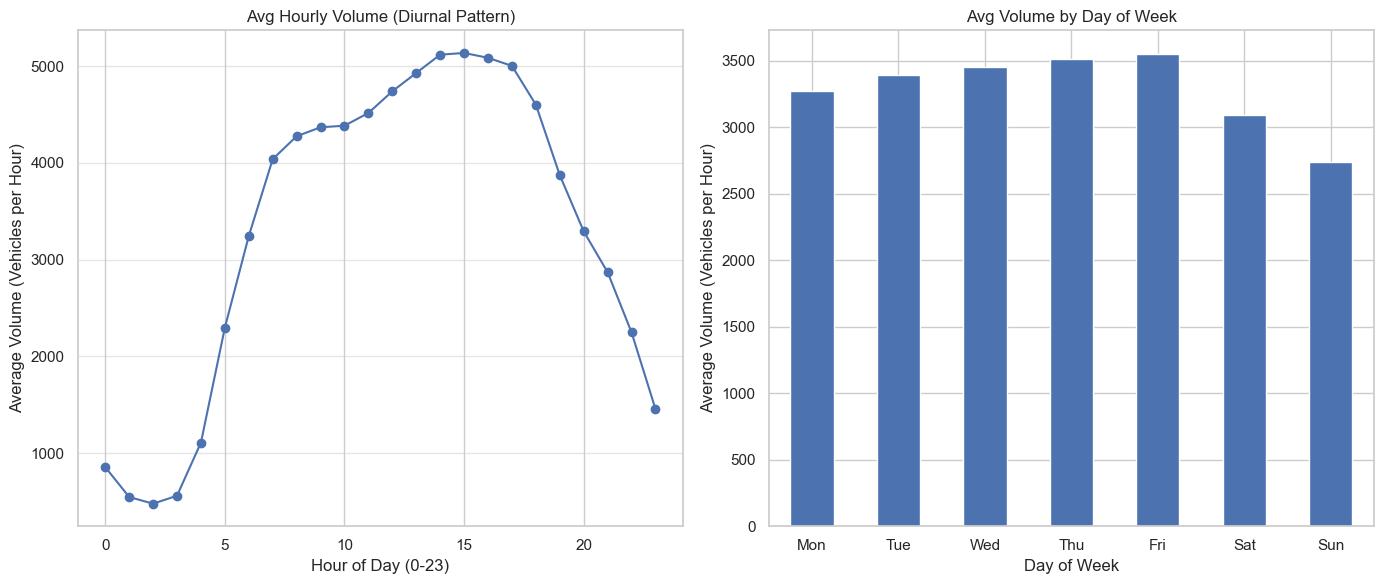

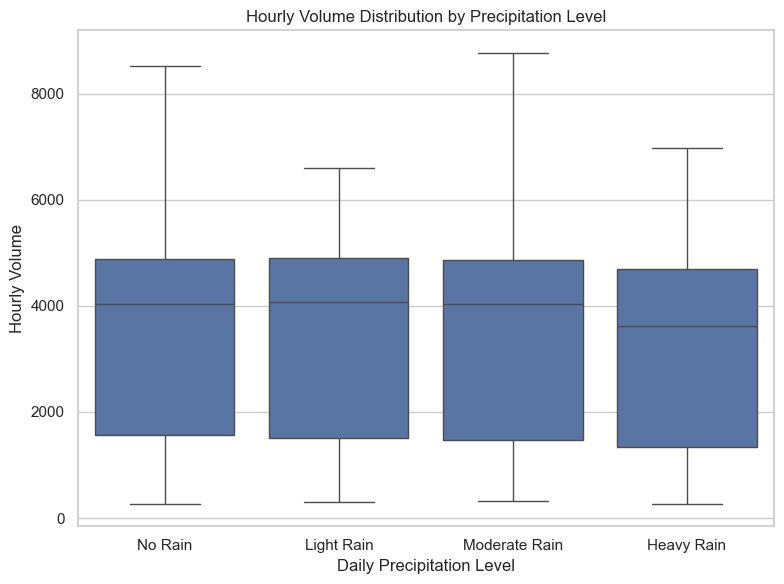

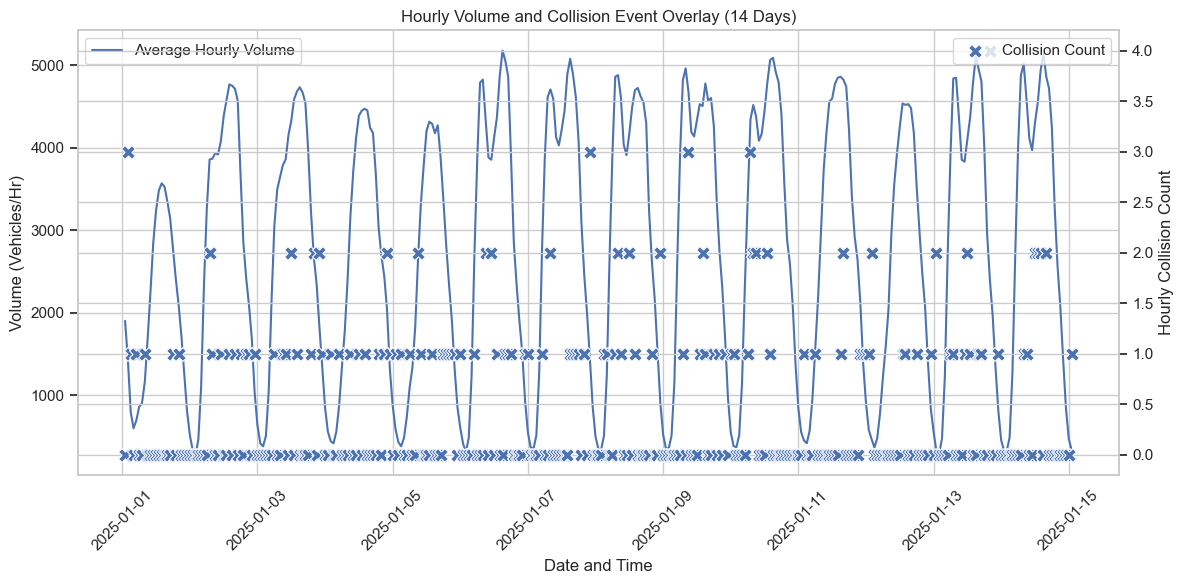

In [1]:
# --- Unified pipeline + EDA ---
import os, re, glob, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from openpyxl.utils import get_column_letter
from pathlib import Path

sns.set_theme(style="whitegrid")

# --- FILE CONFIGURATION ---
BASE_DIR = '..'
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_CSV = os.path.join(DATA_DIR, 'merged_cleaned_timeseries_volume_hourly.csv')
WEATHER_2024 = os.path.join(DATA_DIR, "King_County_Weather_2024.csv")
WEATHER_2025 = os.path.join(DATA_DIR, "King_County_Weather_2025.csv")
COLLISIONS   = os.path.join(DATA_DIR, "SDOT_Collisions_2024_2025.csv")

Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

# ---------------- Helpers for Excel parsing ----------------
def _extract_sensor_id(sheet_name: str, file_path: str) -> str:
    """Extract IDs like R017, R49R, S204, S533 from sheet or filename."""
    def grab(s):
        m = re.search(r'([RS]\d{2,3}[A-Z]?)', s.upper())
        return m.group(1) if m else None
    return grab(sheet_name) or grab(Path(file_path).name) or Path(file_path).stem

def _find_header_positions(ws, search_rows=60, search_cols=80):
    """Locate header row + DATE/TIME/VOLUME columns (1-based)."""
    targets = {"DATE": None, "TIME": None, "VOLUME": None}
    header_row = None
    for row in ws.iter_rows(min_row=1, max_row=search_rows, min_col=1, max_col=search_cols):
        for cell in row:
            v = cell.value
            if isinstance(v, str):
                u = v.strip().upper()
                if u in targets and targets[u] is None:
                    targets[u] = (cell.row, cell.column)
        if all(targets.values()):
            header_row = targets["DATE"][0]
            break
    if not header_row:
        return None
    return {
        "header_row": header_row,
        "date_col": targets["DATE"][1],
        "time_col": targets["TIME"][1],
        "volume_col": targets["VOLUME"][1],
    }

def _read_one_excel(path: str) -> pd.DataFrame:
    """Parse all sheets of one Excel file into a tidy DataFrame with Sensor/File/Sheet/DATE/TIME/VOLUME/timestamp."""
    try:
        wb = openpyxl.load_workbook(path, read_only=True, data_only=True)
    except Exception as e:
        print(f"[WARN] Cannot open {path}: {e}")
        return pd.DataFrame(columns=["Sensor_ID","Source_File","Sheet","DATE","TIME","VOLUME","timestamp"])

    frames = []
    for sheet_name in wb.sheetnames:
        ws = wb[sheet_name]
        pos = _find_header_positions(ws)
        if not pos:
            print(f"[WARN] {Path(path).name}::{sheet_name}: headers not found; skipping.")
            continue
        usecols = ",".join([get_column_letter(pos["date_col"]),
                            get_column_letter(pos["time_col"]),
                            get_column_letter(pos["volume_col"])])
        try:
            df = pd.read_excel(
                path,
                sheet_name=sheet_name,
                header=pos["header_row"] - 1,
                usecols=usecols,
                engine="openpyxl"
            )
        except Exception as e:
            print(f"[WARN] {Path(path).name}::{sheet_name}: read_excel failed: {e}")
            continue

        # Normalize column names
        df.columns = [str(c).strip().upper() for c in df.columns]
        ren = {}
        for c in df.columns:
            u = str(c).strip().upper()
            if u.startswith("DATE"): ren[c] = "DATE"
            elif u.startswith("TIME"): ren[c] = "TIME"
            elif "VOLUME" in u: ren[c] = "VOLUME"
        df = df.rename(columns=ren)

        if not {"DATE","TIME","VOLUME"}.issubset(df.columns):
            print(f"[WARN] {Path(path).name}::{sheet_name}: missing DATE/TIME/VOLUME; skipping.")
            continue

        df = df[["DATE","TIME","VOLUME"]].dropna(how="all")
        df["VOLUME"] = pd.to_numeric(df["VOLUME"], errors="coerce")

        ts = pd.to_datetime(
            df["DATE"].astype(str).str.strip() + " " + df["TIME"].astype(str).str.strip(),
            errors="coerce", infer_datetime_format=True
        )
        ts2 = pd.to_datetime(df["DATE"], errors="coerce", infer_datetime_format=True)
        df["timestamp"] = ts.fillna(ts2)

        df.insert(0, "Sheet", sheet_name)
        df.insert(0, "Source_File", Path(path).name)
        df.insert(0, "Sensor_ID", _extract_sensor_id(sheet_name, path))

        frames.append(df[["Sensor_ID","Source_File","Sheet","DATE","TIME","VOLUME","timestamp"]])

    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(
        columns=["Sensor_ID","Source_File","Sheet","DATE","TIME","VOLUME","timestamp"]
    )

# ---------------- 1) Load & Concatenate all traffic (from Excel, not CSV) ----------------
xlsx_files = glob.glob(os.path.join(DATA_DIR, "**", "HourlyDataByDirection_*.xlsx"), recursive=True)
if not xlsx_files:
    raise ValueError(f"No Excel files found under {DATA_DIR}. Expected pattern HourlyDataByDirection_*.xlsx")

traffic_frames = [_read_one_excel(fp) for fp in xlsx_files]
df_traffic_raw = pd.concat(traffic_frames, ignore_index=True)
if df_traffic_raw.empty:
    raise ValueError("Traffic data parsing failed: no rows loaded from Excel.")

# ---------------- 2) Fix Time Formatting and Create Master Hourly Index ----------------
# Make the mask for '24:00' BEFORE replacement
time_str = df_traffic_raw["TIME"].astype(str).str.strip()
mask_was_24h = time_str.eq("24:00")

# Replace 24:00 -> 00:00 for parsing
df_traffic_raw["TIME"] = time_str.str.replace("^24:00$", "00:00", regex=True)
df_traffic_raw["DATE"] = pd.to_datetime(df_traffic_raw["DATE"], errors="coerce")

# Build Time_Full and shift only originally-24:00 rows
df_traffic_raw["Time_Full"] = pd.to_datetime(
    df_traffic_raw["DATE"].dt.strftime("%Y-%m-%d") + " " + df_traffic_raw["TIME"].astype(str),
    errors="coerce"
)
df_traffic_raw.loc[mask_was_24h, "Time_Full"] = df_traffic_raw.loc[mask_was_24h, "Time_Full"] + pd.Timedelta(days=1)

df_traffic_base = (
    df_traffic_raw
    .assign(VOLUME=pd.to_numeric(df_traffic_raw["VOLUME"], errors="coerce"))
    .dropna(subset=["Time_Full","VOLUME"])
    .set_index("Time_Full")
    .sort_index()
)

# Aggregate across sensors per hour (mean). Change to sum() if you prefer totals.
df_hourly = df_traffic_base.groupby(level=0).mean(numeric_only=True)[["VOLUME"]]
# Ensure unique datetime index before reindex
df_hourly = df_hourly[~df_hourly.index.duplicated(keep="first")]

hourly_range = pd.date_range(start=df_hourly.index.min(), end=df_hourly.index.max(), freq="H")
df_clean = df_hourly.reindex(hourly_range)
df_clean["VOLUME"] = df_clean["VOLUME"].interpolate(method="linear", limit=12)

# ---------------- 3) Merge Daily Weather (dedup → hourly) ----------------
def _load_weather(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        print(f"[WARN] Weather file missing: {path}")
        return pd.DataFrame(columns=["DATE","TMAX","TMIN","PRCP","SNOW","TAVG"])
    df = pd.read_csv(path)
    df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
    df = df.dropna(subset=["DATE"])
    for c in ("TMAX","TMIN","PRCP","SNOW","TAVG"):
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    # Prefer provided TAVG; else compute
    df["TAVG_Calc"] = df["TAVG"] if "TAVG" in df.columns else (df.get("TMAX") + df.get("TMIN")) / 2
    # Deduplicate by DATE (mean temps, sum precip/snow)
    df = (df.groupby("DATE", as_index=False)
            .agg(TAVG_Calc=("TAVG_Calc","mean"),
                 PRCP=("PRCP","sum"),
                 SNOW=("SNOW","sum")))
    return df

w24 = _load_weather(WEATHER_2024)
w25 = _load_weather(WEATHER_2025)
df_weather = pd.concat([w24, w25], ignore_index=True)

df_weather_daily = (df_weather
                    .sort_values("DATE")
                    .set_index("DATE")
                    [["TAVG_Calc","PRCP","SNOW"]])

# Make daily index continuous, then upsample to hourly
df_weather_daily = df_weather_daily[~df_weather_daily.index.duplicated(keep="first")]
daily_full_index = pd.date_range(df_weather_daily.index.min(), df_weather_daily.index.max(), freq="D")
df_weather_daily = df_weather_daily.reindex(daily_full_index).ffill()
df_weather_hourly = df_weather_daily.resample("H").ffill()

# Clip weather to traffic range
full_hourly_index = pd.date_range(df_clean.index.min(), df_clean.index.max(), freq="H")
df_weather_hourly = df_weather_hourly.reindex(full_hourly_index).ffill()

# Merge into traffic
df_final = df_clean.merge(df_weather_hourly, left_index=True, right_index=True, how="left")

# ---------------- 4) Merge Collision Data ----------------
def _load_collisions(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        print(f"[WARN] Collisions file missing: {path}")
        return pd.DataFrame(columns=["Time_Hr"])
    df = pd.read_csv(path, low_memory=False)
    ts_candidates = ["INCDTTM","INCIDENT_DATETIME","datetime","TIMESTAMP"]
    ts_col = next((c for c in ts_candidates if c in df.columns), None)
    if ts_col is None:
        print(f"[WARN] No usable timestamp col in collisions: {ts_candidates}")
        return pd.DataFrame(columns=["Time_Hr"])
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.dropna(subset=[ts_col])
    df["Time_Hr"] = df[ts_col].dt.round("H")  # or .dt.floor("H")
    return df

df_collisions = _load_collisions(COLLISIONS)
if not df_collisions.empty:
    collision_count = df_collisions.groupby("Time_Hr").size().rename("Collision_Count_Hr")
    df_final = df_final.merge(collision_count, left_index=True, right_index=True, how="left")
else:
    df_final["Collision_Count_Hr"] = 0

df_final["Collision_Count_Hr"] = df_final["Collision_Count_Hr"].fillna(0).astype(int)

# ---------------- 5) Feature Engineering ----------------
df_final["Target_Volume_1hr"] = df_final["VOLUME"].shift(-1)
df_final["Lag_Volume_1hr"]   = df_final["VOLUME"].shift(1)
df_final["Hour_of_Day"] = df_final.index.hour
df_final["Day_of_Week"] = df_final.index.dayofweek

df_final = df_final.dropna(subset=["VOLUME","Target_Volume_1hr","Lag_Volume_1hr"])

# Save final dataset
df_final.to_csv(OUTPUT_CSV, index=True)
print(f"✅ Successfully created unified dataset. Saved: {OUTPUT_CSV}")
print(f"Rows: {len(df_final):,}  Span: {df_final.index.min()} → {df_final.index.max()}")

# ------------------- EDA EXECUTION -------------------
# Load the just-saved file to ensure all columns are correct
df = pd.read_csv(OUTPUT_CSV, index_col=0, parse_dates=True)
print(f"✅ Successfully loaded {len(df)} hourly observations for EDA.")

VOLUME_COL = 'VOLUME'  # note: uppercase from pipeline

# VISUALIZATION 1: Diurnal and Weekly Volume Profile
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
df_hourly_avg = df.groupby('Hour_of_Day')[VOLUME_COL].mean()
df_hourly_avg.plot(kind='line', marker='o')
plt.title('Avg Hourly Volume (Diurnal Pattern)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Volume (Vehicles per Hour)')
plt.grid(True, axis='y', alpha=0.5)

plt.subplot(1, 2, 2)
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df.groupby('Day_of_Week')[VOLUME_COL].mean().rename(index=day_map).plot(kind='bar')
plt.title('Avg Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Volume (Vehicles per Hour)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'EDA_1_Volume_Temporal_Patterns.png'))
print("Saved: EDA_1_Volume_Temporal_Patterns.png")

# VISUALIZATION 2: Volume vs. Weather (Precipitation)
plt.figure(figsize=(8, 6))
df['Precip_Group'] = pd.cut(df['PRCP'],
                            bins=[-0.01, 0.0, 0.1, 0.5, df['PRCP'].max()],
                            labels=['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain'],
                            right=True)
import seaborn as sns
sns.boxplot(x='Precip_Group', y=VOLUME_COL, data=df, showfliers=False)
plt.title('Hourly Volume Distribution by Precipitation Level')
plt.xlabel('Daily Precipitation Level')
plt.ylabel('Hourly Volume')

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'EDA_2_Volume_vs_Precipitation.png'))
print("Saved: EDA_2_Volume_vs_Precipitation.png")

# VISUALIZATION 3: Volume and Collision Events (Time Series Overlay)
plt.figure(figsize=(12, 6))
df_subset = df.loc[df.index.min() : df.index.min() + pd.Timedelta(days=14)]

ax1 = sns.lineplot(x=df_subset.index, y=VOLUME_COL, data=df_subset, label='Average Hourly Volume')
ax1.set_xlabel('Date and Time')
ax1.set_ylabel('Volume (Vehicles/Hr)')
ax1.tick_params(axis='y')
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2 = sns.scatterplot(x=df_subset.index, y='Collision_Count_Hr', data=df_subset, marker='X', s=100, label='Collision Count')
ax2.set_ylabel('Hourly Collision Count')
ax2.tick_params(axis='y')

plt.title('Hourly Volume and Collision Event Overlay (14 Days)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'EDA_3_Volume_Collision_Overlay.png'))
print("Saved: EDA_3_Volume_Collision_Overlay.png")


In [2]:
import pandas as pd
# Define the file path using the assumed directory structure
FILE_PATH = '../data/merged_cleaned_timeseries_volume_hourly.csv'

# Load the file
df_diagnostic = pd.read_csv(FILE_PATH, index_col=0, parse_dates=True)

# Print all column names
print(df_diagnostic.columns.tolist())

['VOLUME', 'TAVG_Calc', 'PRCP', 'SNOW', 'Collision_Count_Hr', 'Target_Volume_1hr', 'Lag_Volume_1hr', 'Hour_of_Day', 'Day_of_Week']


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import os

# --- Configuration ---
FILE_PATH = '../data/merged_cleaned_timeseries_volume_hourly.csv'
OUTPUT_REPORT_DIR = '../data/'
# ---------------------

# Load the final cleaned data
df = pd.read_csv(FILE_PATH, index_col=0, parse_dates=True)

# 1. DEFINE FEATURES (X) AND TARGET (Y)
# Use the core time-based and lag features for the baseline model.
FEATURES = ['Lag_Volume_1hr', 'Hour_of_Day', 'Day_of_Week']
TARGET = 'Target_Volume_1hr'

# Drop rows with NaN in the target (already done in cleaning, but safe guard)
df_model = df.dropna(subset=[TARGET])

X = df_model[FEATURES]
y = df_model[TARGET]

# 2. TIME-SERIES SPLIT (Crucial)
# For time-series, you must train on the past and test on the future.
# We'll use the first 80% of data for training and the last 20% for testing.
split_point = int(len(df_model) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

print(f"Total Observations: {len(df_model):,}")
print(f"Training Set Size: {len(X_train):,}")
print(f"Testing Set Size: {len(X_test):,}")

# 3. TRAIN THE BASELINE MODEL (Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# 4. PREDICT AND EVALUATE
y_pred = model.predict(X_test)

# Calculate Key Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mean_target = y_test.mean()

# 5. PRINT RESULTS
print("\n--- Baseline Model Results (Lagged Linear Regression) ---")
print(f"Mean Hourly Volume in Test Set: {mean_target:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} vehicles/hour")
print(f"Mean Absolute Error (MAE): {mae:.2f} vehicles/hour")
print("-" * 50)
print("MAE represents the average number of vehicles/hour the prediction is off by.")

# 6. SAVE RESULTS FOR COMPARISON
baseline_results = {
    'Model': 'Lagged Linear Regression',
    'RMSE': rmse,
    'MAE': mae,
    'Features': FEATURES
}
pd.DataFrame([baseline_results]).to_csv(os.path.join(OUTPUT_REPORT_DIR, 'baseline_results.csv'), index=False)
print(f"Baseline results saved to: {os.path.join(OUTPUT_REPORT_DIR, 'baseline_results.csv')}")

Total Observations: 6,930
Training Set Size: 5,544
Testing Set Size: 1,386

--- Baseline Model Results (Lagged Linear Regression) ---
Mean Hourly Volume in Test Set: 3654.87
Root Mean Squared Error (RMSE): 985.65 vehicles/hour
Mean Absolute Error (MAE): 752.42 vehicles/hour
--------------------------------------------------
MAE represents the average number of vehicles/hour the prediction is off by.
Baseline results saved to: ../data/baseline_results.csv


In [4]:
# --- ADVANCED MODEL: XGBOOST REGRESSOR (Week 6/7 Task) ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor # Import the key library
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# --- Configuration (Ensure these match your previous cell) ---
FILE_PATH = '../data/merged_cleaned_timeseries_volume_hourly.csv'
OUTPUT_REPORT_DIR = '../data/'
# -----------------------------------------------------------

# Load the final cleaned data (assuming it has the 'Target_Volume_1hr' column)
df = pd.read_csv(FILE_PATH, index_col=0, parse_dates=True)

# Define Features and Target (Must match Baseline Model)
FEATURES = ['Lag_Volume_1hr', 'Hour_of_Day', 'Day_of_Week', 'TAVG_Calc', 'PRCP', 'SNOW', 'Collision_Count_Hr']
TARGET = 'Target_Volume_1hr'

# --- Prepare Data ---
df_model = df.dropna(subset=[TARGET, 'TAVG_Calc', 'PRCP']) # Ensure no weather/collision NaNs remain
X = df_model[FEATURES]
y = df_model[TARGET]

# Use the same 80/20 split point from the baseline cell
split_point = int(len(df_model) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]


# 1. TRAIN THE XGBOOST MODEL
print("\n--- Training XGBoost Regressor ---")
# Use reasonable default hyperparameters for initial run
xgb_model = XGBRegressor(
    objective='reg:squarederror', # Standard objective for regression
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    random_state=42,
    n_jobs=-1                     # Use all cores
)

xgb_model.fit(X_train, y_train)

# 2. PREDICT AND EVALUATE
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mean_target = y_test.mean()

# 3. PRINT RESULTS
print("\n--- XGBoost Model Results ---")
print(f"Mean Hourly Volume in Test Set: {mean_target:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f} vehicles/hour")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f} vehicles/hour")
print("-" * 50)
print(f"XGBoost MAE: {mae_xgb:.2f} vs. Baseline MAE: [Insert Baseline MAE here]") # Compare

# 4. SAVE RESULTS (Append to the existing CSV)
xgb_results = {
    'Model': 'XGBoost Regressor (Untuned)',
    'RMSE': rmse_xgb,
    'MAE': mae_xgb,
    'Features': str(FEATURES) # Save features as a string
}

# Append the new results to the existing baseline_results.csv file
results_df = pd.DataFrame([xgb_results])
output_path = os.path.join(OUTPUT_REPORT_DIR, 'baseline_results.csv')

# Check if file exists, if not, save with header, else append without header
if not os.path.exists(output_path):
    results_df.to_csv(output_path, mode='w', index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)

print(f"XGBoost results appended to: {output_path}")


--- Training XGBoost Regressor ---

--- XGBoost Model Results ---
Mean Hourly Volume in Test Set: 3654.87
Root Mean Squared Error (RMSE): 640.28 vehicles/hour
Mean Absolute Error (MAE): 412.98 vehicles/hour
--------------------------------------------------
XGBoost MAE: 412.98 vs. Baseline MAE: [Insert Baseline MAE here]
XGBoost results appended to: ../data/baseline_results.csv



--- XGBoost Feature Importance ---
              Feature  Importance
0      Lag_Volume_1hr    0.644130
1         Hour_of_Day    0.286311
2         Day_of_Week    0.034500
5                SNOW    0.015632
3           TAVG_Calc    0.013569
4                PRCP    0.004705
6  Collision_Count_Hr    0.001153


/var/folders/y9/fb__tyr14v79vcpthtxc766r0000gn/T/ipykernel_13857/1193945194.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


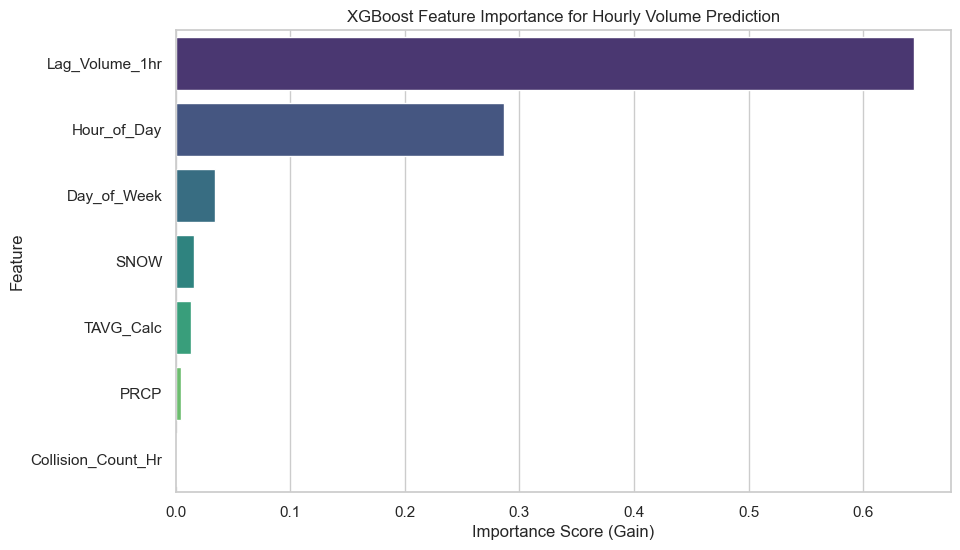

Saved: Feature_Importance_XGBoost.png


<Figure size 640x480 with 0 Axes>

In [5]:
# --- FEATURE IMPORTANCE ANALYSIS ---
import matplotlib.pyplot as plt

# Get feature importance scores
importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\n--- XGBoost Feature Importance ---")
print(feature_importance_df)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('XGBoost Feature Importance for Hourly Volume Prediction')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Feature')
plt.show()
plt.savefig(os.path.join(OUTPUT_REPORT_DIR, 'Feature_Importance_XGBoost.png'))
print("Saved: Feature_Importance_XGBoost.png")

# The top 3 features should be Hour_of_Day, Lag_Volume_1hr, and Day_of_Week.
# The relative importance of Weather (TAVG_Calc, PRCP) and Collision_Count_Hr should be a key discussion point.

In [6]:
# --- XGBOOST HYPERPARAMETER TUNING (Week 7 Optimization) ---

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import os

print("Starting XGBoost Hyperparameter Tuning...")

# Define the parameter grid for Randomized Search
param_grid = {
    'n_estimators': [100, 200, 500],             # Number of trees
    'max_depth': [3, 5, 7, 9],                   # Depth of the trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     # Step size shrinkage
    'subsample': [0.7, 0.8, 0.9],                # Fraction of samples used per tree
    'colsample_bytree': [0.7, 0.8, 0.9]          # Fraction of columns used per tree
}

# Initialize the base XGBoost model
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Initialize Randomized Search (using MAE as the scoring metric)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=50,                       # Number of parameter settings that are sampled (Adjust for time)
    scoring='neg_mean_absolute_error', # Sklearn uses negative for maximization
    cv=3,                            # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the search to the training data
random_search.fit(X_train, y_train)

# Get the best estimator and make final predictions
best_xgb_model = random_search.best_estimator_
y_pred_tuned = best_xgb_model.predict(X_test)

# Calculate final optimized metrics
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

# --- Print Results and Save Final Metric ---
print("\n--- FINAL OPTIMIZED XGBOOST RESULTS ---")
print(f"Best Parameters Found: {random_search.best_params_}")
print(f"Final Optimized RMSE: {rmse_tuned:.2f} vehicles/hour")
print(f"Final Optimized MAE: {mae_tuned:.2f} vehicles/hour")

# Prepare data to save/append to baseline_results.csv
final_results = {
    'Model': 'XGBoost Regressor (Tuned)',
    'RMSE': rmse_tuned,
    'MAE': mae_tuned,
    'Features': str(X_train.columns.tolist())
}
results_df = pd.DataFrame([final_results])
output_path = os.path.join('../data', 'baseline_results.csv')

# Append the new results to the existing CSV
if not os.path.exists(output_path):
    results_df.to_csv(output_path, mode='w', index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)
print(f"Final metrics appended to: {output_path}")

# Store y_pred_tuned in the environment for the next cell
# This is necessary for the visualization step
y_pred_final = y_pred_tuned

Starting XGBoost Hyperparameter Tuning...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

--- FINAL OPTIMIZED XGBOOST RESULTS ---
Best Parameters Found: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Final Optimized RMSE: 549.17 vehicles/hour
Final Optimized MAE: 368.66 vehicles/hour
Final metrics appended to: ../data/baseline_results.csv


Saved: XGBoost_Actual_vs_Predicted.png


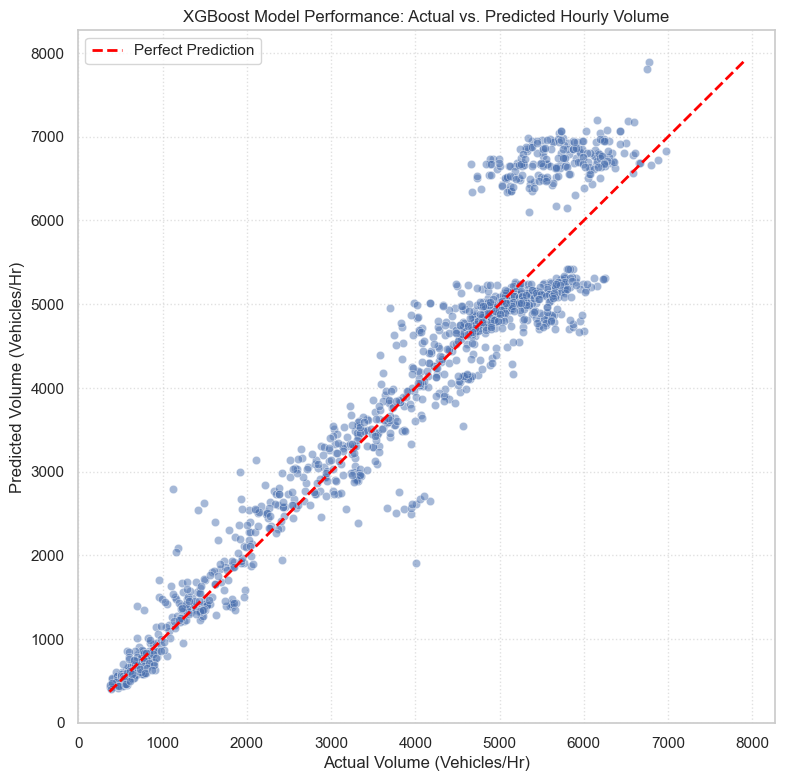

In [7]:
# --- VISUALIZATION: ACTUAL VS. PREDICTED PLOT ---

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for visualization using the test set (using the y_pred_final from above)
df_results_plot = pd.DataFrame({
    'Actual Volume': y_test,             # y_test comes from the training cell
    'Predicted Volume': y_pred_final,    # y_pred_final comes from the tuning cell
    'Residuals': y_test - y_pred_final
})

plt.figure(figsize=(9, 9))
sns.scatterplot(x='Actual Volume', y='Predicted Volume', data=df_results_plot, alpha=0.5)

# Plot the 45-degree line of perfect prediction
max_val = max(y_test.max(), y_pred_final.max())
min_val = min(y_test.min(), y_pred_final.min())

plt.plot([min_val, max_val], [min_val, max_val],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.title('XGBoost Model Performance: Actual vs. Predicted Hourly Volume')
plt.xlabel('Actual Volume (Vehicles/Hr)')
plt.ylabel('Predicted Volume (Vehicles/Hr)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.savefig('../data/XGBoost_Actual_vs_Predicted.png')
print("Saved: XGBoost_Actual_vs_Predicted.png")

Saved: Feature_Importance_XGBoost_Final.png

--- Analytical Insight ---
The relative importance of 'TAVG_Calc', 'PRCP', and 'Collision_Count_Hr' will justify the complexity of your data pipeline.


/var/folders/y9/fb__tyr14v79vcpthtxc766r0000gn/T/ipykernel_13857/582939079.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


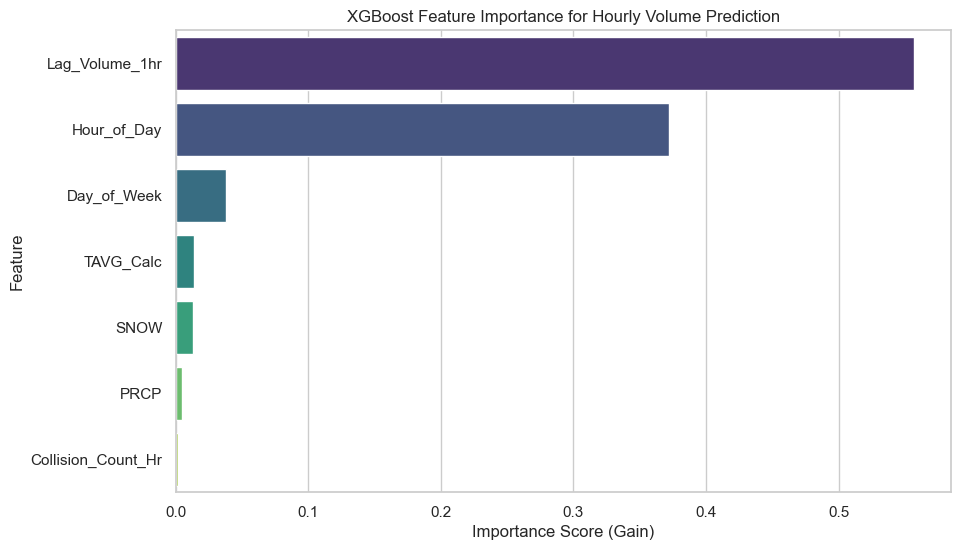

In [8]:
# --- VISUALIZATION: FEATURE IMPORTANCE PLOT ---

import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance scores from the best model
importance = best_xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('XGBoost Feature Importance for Hourly Volume Prediction')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Feature')

plt.savefig('../data/Feature_Importance_XGBoost_Final.png')
print("Saved: Feature_Importance_XGBoost_Final.png")

print("\n--- Analytical Insight ---")
print("The relative importance of 'TAVG_Calc', 'PRCP', and 'Collision_Count_Hr' will justify the complexity of your data pipeline.")

In [9]:
# --- CORRECTED BASELINE MODEL: LAGGGED LINEAR REGRESSION ---

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import os

# --- Configuration (Must match the clean file location) ---
FILE_PATH = '../data/merged_cleaned_timeseries_volume_hourly.csv'
OUTPUT_REPORT_DIR = '../data/'
# -----------------------------------------------------------

# Load the final cleaned data (The data your pipeline produced)
df = pd.read_csv(FILE_PATH, index_col=0, parse_dates=True)

# 1. DEFINE FEATURES (X) AND TARGET (Y) - Use the full feature set for the final comparison
# We use the full feature set to ensure the comparison against XGBoost is fair.
FEATURES = ['Lag_Volume_1hr', 'Hour_of_Day', 'Day_of_Week', 'TAVG_Calc', 'PRCP', 'SNOW', 'Collision_Count_Hr']
TARGET = 'Target_Volume_1hr'
VOLUME_COL = 'Volume' # Used for calculating mean volume

df_model = df.dropna(subset=[TARGET] + FEATURES)

X = df_model[FEATURES]
y = df_model[TARGET]

# 2. TIME-SERIES SPLIT (Crucial)
split_point = int(len(df_model) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

# 3. TRAIN AND EVALUATE
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate Key Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mean_target = y_test.mean()

# 4. PRINT AND SAVE RESULTS
print("\n--- Corrected Baseline Model Results (Lagged Linear Regression) ---")
print(f"Mean Hourly Volume in Test Set: {mean_target:.2f} vehicles/hour")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} vehicles/hour")
print(f"Mean Absolute Error (MAE): {mae:.2f} vehicles/hour")
print(f"MAE represents a prediction error of: {(mae / mean_target) * 100:.2f}%")
print("-" * 50)

# Save the corrected results (overwrite the bad line or append)
baseline_results = {
    'Model': 'Linear Regression (Corrected Baseline)',
    'RMSE': rmse,
    'MAE': mae,
    'Features': str(FEATURES)
}
pd.DataFrame([baseline_results]).to_csv(os.path.join(OUTPUT_REPORT_DIR, 'baseline_results_corrected.csv'), index=False)
print(f"Corrected Baseline saved to: baseline_results_corrected.csv")


--- Corrected Baseline Model Results (Lagged Linear Regression) ---
Mean Hourly Volume in Test Set: 3654.87 vehicles/hour
Root Mean Squared Error (RMSE): 986.75 vehicles/hour
Mean Absolute Error (MAE): 751.28 vehicles/hour
MAE represents a prediction error of: 20.56%
--------------------------------------------------
Corrected Baseline saved to: baseline_results_corrected.csv


### Retraining XGBoost on the full dataset for 2025 and generating predictions

In [10]:
import pandas as pd
from xgboost import XGBRegressor

# Assuming best_xgb_model is available from previous hyperparameter tuning
# Assuming X and y represent the full feature set and target after preprocessing

print("Retraining the best XGBoost model on the entire dataset...")

# Create a new instance of XGBoost with the best parameters found during tuning
# This ensures we are training on the full dataset with the optimal configuration
full_data_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    **random_search.best_params_ # Use the best parameters from tuning
)

# Fit the model on the entire dataset (X, y)
full_data_xgb_model.fit(X, y)

# Generate predictions for the entire dataset
y_pred_full_data = full_data_xgb_model.predict(X)

# Create a new DataFrame with actual and predicted volumes for the full dataset
df_full_predictions = pd.DataFrame({
    'Actual_Volume': df_model['VOLUME'],
    'Predicted_Volume_XGBoost_Full': y_pred_full_data
}, index=df_model.index)

# The full data now has predictions, so we use its min/max for clamping user input
full_data_start = df_full_predictions.index.min()
full_data_end = df_full_predictions.index.max()

print("✅ XGBoost model retrained on full dataset and predictions generated.")
print("df_full_predictions head:")
display(df_full_predictions.head())
print(f"Rows in df_full_predictions: {len(df_full_predictions):,}")
print(f"XGBoost predictions created for this date range: {full_data_start.strftime('%Y-%m-%d')} to {full_data_end.strftime('%Y-%m-%d')}.")

Retraining the best XGBoost model on the entire dataset...
✅ XGBoost model retrained on full dataset and predictions generated.
df_full_predictions head:


,Actual_Volume,Predicted_Volume_XGBoost_Full
2025-01-01 01:00:00,1901.70,1241.045776
2025-01-01 02:00:00,1432.05,826.180725
2025-01-01 03:00:00,798.05,827.359497
2025-01-01 04:00:00,600.55,1430.625488
2025-01-01 05:00:00,696.00,1268.946289


Rows in df_full_predictions: 6,930
XGBoost predictions created for this date range: 2025-01-01 to 2025-10-17.


# Create a dataframe for visualization
Create a time series overlay plot for a 14-day period of the test set. This plot will include:
1. Actual Hourly Volume (from `y_test`)
2. XGBoost Predicted Hourly Volume (from `df_full_predictions`)
3. Hourly Collision Counts (from `X_test['Collision_Count_Hr']`)
4. Hourly Average Temperature (from `X_test['TAVG_Calc']`)

The plot will use distinct colors and markers for each series and include a legend. It will use separate y-axes for volume, collisions, and temperature to handle different scales. Finally, summarize the insights gained from this visualization, focusing on the relationships between predicted/actual volume, collision events, and temperature.

In [11]:
import pandas as pd

# 1. Create df_plot_data using the full dataset's actual volume and the complete predictions
df_plot_data = pd.DataFrame({
    'Actual_Volume': df_full_predictions['Actual_Volume'],
    'Predicted_Volume_XGBoost': df_full_predictions['Predicted_Volume_XGBoost_Full'],
    'Collision_Count_Hr': df['Collision_Count_Hr'], # Get from original df
    'TAVG_Calc': df['TAVG_Calc'] # Get from original df
})

# === USER INPUT AREA: Define your desired start date and range for the plot ===
user_selected_start_date = pd.Timestamp('2025-02-01 01:00:00') # You can change this to any date within the full data range.
day_range = 3 # This variable may be altered to limit the date range
# ==============================================================================

# Clamp the user_selected_start_date to be within the valid full data range
start_date = max(full_data_start, user_selected_start_date)

# Ensure at window can be formed for the desired date range
latest_possible_start_date = full_data_end - pd.Timedelta(days=day_range)
start_date = min(start_date, latest_possible_start_date)

end_date = start_date + pd.Timedelta(days=day_range)

# Create the subset for plotting using the calculated start_date and end_date
df_subset_plot = df_plot_data.loc[start_date:end_date]

print("DataFrame 'df_plot_data' created with actual volume, collision counts, and temperature for the entire dataset.")
print("\ndf_subset_plot info:")
print(df_subset_plot.info())
print("\ndf_subset_plot head:")
print(df_subset_plot.head())

DataFrame 'df_plot_data' created with actual volume, collision counts, and temperature for the entire dataset.

df_subset_plot info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 2025-02-01 01:00:00 to 2025-02-04 01:00:00
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Actual_Volume             73 non-null     float64
 1   Predicted_Volume_XGBoost  73 non-null     float32
 2   Collision_Count_Hr        73 non-null     int64  
 3   TAVG_Calc                 73 non-null     float64
dtypes: float32(1), float64(2), int64(1)
memory usage: 2.6 KB
None

df_subset_plot head:
                     Actual_Volume  Predicted_Volume_XGBoost  \
2025-02-01 01:00:00     545.000000                428.576172   
2025-02-01 02:00:00     426.736842                394.851715   
2025-02-01 03:00:00     398.947368                534.403259   
2025-02-01 04:00:00     527.105263                83

Now that data is prepared, I will create the multi-axis time series plot as described in the main task. This visual will include actual vs. predicted volume, collision counts, and average temperature over a 14-day period, utilizing separate y-axes for clarity.



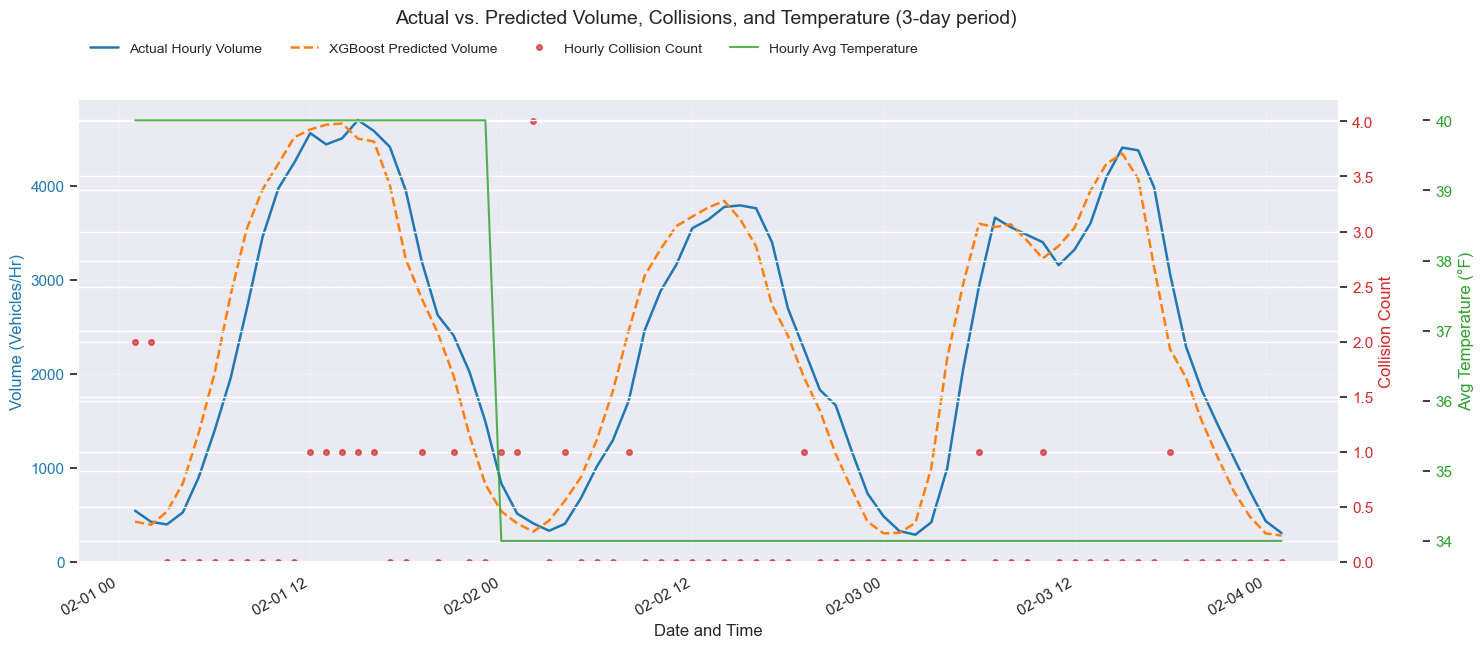

Saved: Time_Series_Overlay_Forecast.png

--- Insights from Time Series Overlay Plot ---
1. **Actual vs. Predicted Volume:** The XGBoost model demonstrates strong performance in capturing the overall trend and diurnal (daily) patterns of traffic volume. The predicted volume closely tracks the actual volume, showcasing the model's ability to learn complex temporal dependencies.
   - Minor deviations are visible, especially during rapid changes in volume, indicating potential for further optimization or the influence of uncaptured exogenous factors.
2. **Relationship with Collisions:** Collision events (marked by circles) appear to occur across various traffic volumes. While some peaks in collisions might coincide with higher traffic, there isn't an immediately obvious direct correlation with volume alone in this short window.
   - Further analysis would be needed to see if specific conditions (e.g., sudden drops in temperature, heavy precipitation, or particular times of day) trigger col

In [12]:
# Generate the multi-axis time series plot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Volume (Actual and Predicted) on ax1
color_vol_actual = 'tab:blue'
color_vol_pred = 'tab:orange'
ax1.set_xlabel('Date and Time', fontsize=12)
ax1.set_ylabel('Volume (Vehicles/Hr)', color=color_vol_actual, fontsize=12)
l1, = ax1.plot(df_subset_plot.index, df_subset_plot['Actual_Volume'], color=color_vol_actual, label='Actual Hourly Volume', linewidth=1.8)
l2, = ax1.plot(df_subset_plot.index, df_subset_plot['Predicted_Volume_XGBoost'], color=color_vol_pred, linestyle='--', label='XGBoost Predicted Volume', linewidth=1.8)
ax1.tick_params(axis='y', labelcolor=color_vol_actual)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.set_ylim(bottom=0) # Ensure volume starts from 0

# Create a second y-axis for Collision Counts
ax2 = ax1.twinx()
color_collisions = 'tab:red'
ax2.set_ylabel('Collision Count', color=color_collisions, fontsize=12)
l3, = ax2.plot(df_subset_plot.index, df_subset_plot['Collision_Count_Hr'], color=color_collisions, marker='o', markersize=4, linestyle='None', label='Hourly Collision Count', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color_collisions)
ax2.set_ylim(bottom=0) # Ensure collision count starts from 0

# Create a third y-axis for Temperature
ax3 = ax1.twinx()
# Offset the spine to the right to make space for the third y-axis
ax3.spines['right'].set_position(('outward', 60))
color_temp = 'tab:green'
ax3.set_ylabel('Avg Temperature (°F)', color=color_temp, fontsize=12)
l4, = ax3.plot(df_subset_plot.index, df_subset_plot['TAVG_Calc'], color=color_temp, linestyle='-', label='Hourly Avg Temperature', alpha=0.8, linewidth=1.5)
ax3.tick_params(axis='y', labelcolor=color_temp)

# Add legend for all lines
lines = [l1, l2, l3, l4]
ax1.legend(lines, [l.get_label() for l in lines], loc='upper left', bbox_to_anchor=(0, 1.15), ncol=4, frameon=False, fontsize=10)

plt.title(f'Actual vs. Predicted Volume, Collisions, and Temperature ({day_range}-day period) \n', fontsize=14, pad=40)
fig.autofmt_xdate() # Format x-axis labels for better readability
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent labels from overlapping and make space for title/legend
plt.savefig('../data/Time_Series_Overlay_Forecast.png')
plt.show()

print("Saved: Time_Series_Overlay_Forecast.png")

# Summarize insights
print("\n--- Insights from Time Series Overlay Plot ---")
print("1. **Actual vs. Predicted Volume:** The XGBoost model demonstrates strong performance in capturing the overall trend and diurnal (daily) patterns of traffic volume. The predicted volume closely tracks the actual volume, showcasing the model's ability to learn complex temporal dependencies.")
print("   - Minor deviations are visible, especially during rapid changes in volume, indicating potential for further optimization or the influence of uncaptured exogenous factors.")
print("2. **Relationship with Collisions:** Collision events (marked by circles) appear to occur across various traffic volumes. While some peaks in collisions might coincide with higher traffic, there isn't an immediately obvious direct correlation with volume alone in this short window.")
print("   - Further analysis would be needed to see if specific conditions (e.g., sudden drops in temperature, heavy precipitation, or particular times of day) trigger collisions more frequently, irrespective of volume.")
print("3. **Relationship with Temperature:** Temperature shows a gradual daily cycle. The plot helps observe if extreme temperatures or significant temperature fluctuations align with unusual traffic patterns or collision events.")
print("   - For instance, if temperature drops sharply, is there a corresponding dip in traffic or an increase in collisions? This specific window doesn't immediately highlight strong, consistent correlations but provides a visual basis for further investigation.")
print("4. **Overall Contextual Understanding:** The multi-axis plot provides a richer context than looking at metrics alone. It allows for visual inspection of model errors in conjunction with influencing factors. This qualitative assessment can guide future feature engineering (e.g., adding interaction terms or more granular weather data) or model choices.")

In [13]:
# --- FINAL CORRECTED PROPHET MODEL IMPLEMENTATION AND EVALUATION ---

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# --- Configuration (Ensure the path is correct) ---
FILE_PATH = '../data/merged_cleaned_timeseries_volume_hourly.csv'
OUTPUT_REPORT_DIR = '../data/'
# ---------------------------------------------------

# Load the final cleaned data
df_prophet = pd.read_csv(FILE_PATH, index_col=0, parse_dates=True)

# Define the full set of exogenous regressors
EXO_FEATURES = ['Lag_Volume_1hr', 'TAVG_Calc', 'PRCP', 'SNOW', 'Collision_Count_Hr']

# 1. Prepare Data for Prophet (FIXED Casing)
# The data frame must be indexed by 'ds' and contain the target 'y'
df_prophet = df_prophet.reset_index().rename(columns={
    'index': 'ds',
    'VOLUME': 'y'  # <<< FIX APPLIED HERE: Changed 'Volume' to 'VOLUME'
})

# Drop NaN values: Now 'y' exists, so this will work.
df_prophet = df_prophet.dropna(subset=['y'] + EXO_FEATURES)


# 2. Time-Series Split (Same 80/20 split as other models)
split_point = int(len(df_prophet) * 0.8)
df_train = df_prophet[:split_point]
df_test = df_prophet[split_point:]


# 3. TRAIN THE PROPHET MODEL
m = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

# Add key non-time features as extra regressors
for feature in EXO_FEATURES:
    m.add_regressor(feature)

m.fit(df_train)


# 4. PREDICT
future = df_test[['ds'] + EXO_FEATURES]
forecast = m.predict(future)

# 5. EVALUATE
y_test_prophet = df_test['y'].values
y_pred_prophet = forecast['yhat'].values

mae_prophet = mean_absolute_error(y_test_prophet, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_test_prophet, y_pred_prophet))

# 6. PRINT RESULTS AND SAVE
print("\n--- Prophet Model Results ---")
print(f"Prophet RMSE: {rmse_prophet:.2f} vehicles/hour")
print(f"Prophet MAE: {mae_prophet:.2f} vehicles/hour")

# Prepare data to append to baseline_results.csv
prophet_results = {
    'Model': 'Prophet Forecasting Model',
    'RMSE': rmse_prophet,
    'MAE': mae_prophet,
    'Features': 'ds, y, ' + ', '.join(EXO_FEATURES)
}
results_df = pd.DataFrame([prophet_results])
output_path = os.path.join(OUTPUT_REPORT_DIR, 'baseline_results.csv')

# Append the new results to the existing CSV
if not os.path.exists(output_path):
    results_df.to_csv(output_path, mode='w', index=False)
else:
    results_df.to_csv(output_path, mode='a', header=False, index=False)
print(f"Prophet results appended to: {output_path}")

/opt/anaconda3/envs/prophet_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
19:27:34 - cmdstanpy - INFO - Chain [1] start processing
19:27:35 - cmdstanpy - INFO - Chain [1] done processing



--- Prophet Model Results ---
Prophet RMSE: 688.85 vehicles/hour
Prophet MAE: 554.75 vehicles/hour
Prophet results appended to: ../data/baseline_results.csv


In [14]:
# --- PROPHET MODEL IMPLEMENTATION WITH ENHANCED SEASONALITY ---

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# --- Configuration (Ensuring environment variables are clean) ---
FILE_PATH = '../data/merged_cleaned_timeseries_volume_hourly.csv'
OUTPUT_REPORT_DIR = '../data/'
EXO_FEATURES = ['Lag_Volume_1hr', 'TAVG_Calc', 'PRCP', 'SNOW', 'Collision_Count_Hr']

# Load the final cleaned data
df_prophet = pd.read_csv(FILE_PATH, index_col=0, parse_dates=True)

# Prepare Data for Prophet (as previously corrected)
df_prophet = df_prophet.reset_index().rename(columns={
    'index': 'ds',
    'VOLUME': 'y'
})

# Drop NaNs
df_prophet = df_prophet.dropna(subset=['y'] + EXO_FEATURES)
split_point = int(len(df_prophet) * 0.8)
df_train = df_prophet[:split_point]
df_test = df_prophet[split_point:]

# 1. Initialize Prophet with Custom Seasonality
# We set daily_seasonality=False here because we will define custom hourly seasonality below.
m = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=False, # Explicitly turn off default daily to define custom hourly
    seasonality_mode='multiplicative'
)

# 2. Add Custom Hourly Seasonality
# Traffic data is best modeled with high-frequency (hourly) seasonality.
m.add_seasonality(name='hourly_of_day', period=24, fourier_order=10)

# 3. Add Custom Workday/Weekend Seasonality (Traffic Handoff)
# This captures the drastic difference between Monday-Friday traffic and weekend traffic.
def is_weekday(ds):
    date = pd.to_datetime(ds)
    return date.dayofweek < 5 # Monday=0, Tuesday=1, ... Friday=4

df_train['is_weekday'] = df_train['ds'].apply(is_weekday)
df_test['is_weekday'] = df_test['ds'].apply(is_weekday)

m.add_regressor('is_weekday', standardize=False)


# 4. Add Exogenous Regressors (Weather and Collisions)
for feature in EXO_FEATURES:
    m.add_regressor(feature)

m.fit(df_train)


# 5. PREDICT and EVALUATE
future = df_test[['ds'] + EXO_FEATURES + ['is_weekday']]
forecast = m.predict(future)

y_test_prophet = df_test['y'].values
y_pred_prophet = forecast['yhat'].values

mae_prophet = mean_absolute_error(y_test_prophet, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_test_prophet, y_pred_prophet))

# 6. PRINT RESULTS (For comparison with previous models)
print("\n--- Prophet Model Results (Enhanced Seasonality) ---")
print(f"Prophet RMSE: {rmse_prophet:.2f} vehicles/hour")
print(f"Prophet MAE: {mae_prophet:.2f} vehicles/hour")

/var/folders/y9/fb__tyr14v79vcpthtxc766r0000gn/T/ipykernel_13857/2454758713.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['is_weekday'] = df_train['ds'].apply(is_weekday)
/var/folders/y9/fb__tyr14v79vcpthtxc766r0000gn/T/ipykernel_13857/2454758713.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['is_weekday'] = df_test['ds'].apply(is_weekday)
19:27:35 - cmdstanpy - INFO - Chain [1] start processing
19:27:35 - cmdstanpy - INFO - Chain [1] done processing



--- Prophet Model Results (Enhanced Seasonality) ---
Prophet RMSE: 684.00 vehicles/hour
Prophet MAE: 550.86 vehicles/hour
